In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from collections import Counter
import math

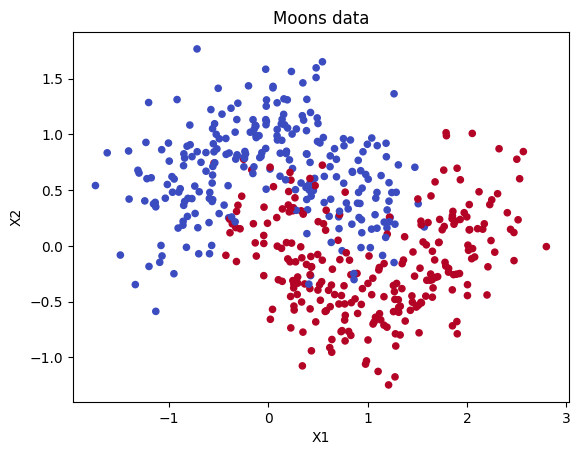

In [51]:
data = np.load('moons_data.npz')
X = data['X']
y = data['y']

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="coolwarm")
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Moons data")
plt.show()

In [52]:
class DecisionTree:
    def __init__(self, max_depth=None, criterion="gini"):
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree = None

    def fit(self, X, y, w=None):
        if w is None:
            w = np.ones(len(y)) / len(y)
        self.tree = self.grow_tree(X, y, w)

    def grow_tree(self, X, y, w, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(set(y))

        # regularization - stop if max_depth is reached or if there is only one label
        if (depth >= self.max_depth or num_labels == 1):
            return {"label": Counter(y).most_common(1)[0][0]}
        
        best_split = self.best_split(X, y, w, num_features)

        if best_split["gain"] == 0:
            return {"label": Counter(y).most_common(1)[0][0]}

        left = self.grow_tree(best_split["X_left"], best_split["y_left"], best_split["w_left"], depth + 1)
        right = self.grow_tree(best_split["X_right"], best_split["y_right"], best_split["w_right"], depth + 1)

        return {
            "feature": best_split["feature"],
            "threshold": best_split["threshold"],
            "left": left,
            "right": right,
        }

    # Find the best split for the current node in the tree with respect to one feature
    # input: X, y, num_features
    # output: split -> dictionary containing the feature, threshold, gain, X_left, y_left, X_right, y_right
    def best_split(self, X, y, w, num_features):

        best_gain = -1
        feature, threshold, gain, X_left, w_left, X_right, y_left, y_right, w_right = None, None, None , None, None, None, None, None, None
        split = {
            "feature": feature,
            "threshold": threshold,
            "gain": gain,
            "X_left": X_left,
            "y_left": y_left,
            "X_right": X_right,
            "y_right": y_right,
            "w_left": w_left,
            "w_right": w_right
        }
        
        ########## Your code goes here ##########
        for feature in range(num_features):
            X_col = X[:, feature]
            unique_values = np.unique(X_col)
            thresholds = (unique_values[:-1] + unique_values[1:]) / 2
            for threshold in thresholds:
                gain, X_left, y_left, w_left, X_right, y_right, w_right = self.split(X, y, w, feature, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split = {
                        "feature": feature,
                        "threshold": threshold,
                        "gain": gain,
                        "X_left": X_left,
                        "y_left": y_left,
                        "X_right": X_right,
                        "y_right": y_right,
                        "w_left": w_left,
                        "w_right": w_right
                    }
        ###########################################

        return split

    # split the data into two regions based on the feature and threshold and computes the information gain
    def split(self, X, y, w, feature, threshold):
        left_idx = X[:, feature] <= threshold
        right_idx = ~left_idx

        X_left, y_left, w_left = X[left_idx], y[left_idx], w[left_idx]
        X_right, y_right, w_right = X[right_idx], y[right_idx], w[right_idx]

        if len(y_left) == 0 or len(y_right) == 0:
            return 0, X_left, y_left, w_left, X_right, y_right, w_right

        gain = self.information_gain(y, y_left, y_right, w, w_left, w_right)

        return gain, X_left, y_left, w_left, X_right, y_right, w_right

    # Compute the information gain
    # Note that you must weight the left and right child nodes by the number of samples in each
    def information_gain(self, y, y_left, y_right, w, w_left, w_right):

        gain = None

        ########## Your code goes here ##########
        n_left = len(y_left)
        n_right = len(y_right)
        W = np.sum(w)
        W_left = np.sum(w_left)
        W_right = np.sum(w_right)

        if n_left == 0 or n_right == 0:
            return 0
        if self.criterion == "gini":
            impurity_parent = self.gini(y, w)
            impurity_left = self.gini(y_left, w_left)
            impurity_right = self.gini(y_right, w_right)
        else:
            impurity_parent = self.entropy(y, w)
            impurity_left = self.entropy(y_left, w_left)
            impurity_right = self.entropy(y_right, w_right)

        gain = impurity_parent - (W_left/W) * impurity_left - (W_right/W) * impurity_right


        ###########################################

        return gain

    # Compute the gini impurity
    def gini(self, y, w):

        gini_impurity = None

        ########## Your code goes here ##########
        classes = np.unique(y)
        w = w / np.sum(w)
        gini_impurity = 1 - sum((np.sum(w[y == c]))**2 for c in classes)

        ###########################################

        return gini_impurity

    # Compute the entropy
    def entropy(self, y, w):

        entropy_value = None

        ########## Your code goes here ##########
        w = w / np.sum(w)
        classes = np.unique(y)
        probs = [np.sum(w[y == c]) for c in classes]
        entropy_value = -np.sum(p * np.log2(p + 1e-9) for p in probs)

        ###########################################

        return entropy_value
    
    # Predict for a vector of inputs
    def predict(self, X):
        return np.array([self.predict_single(inputs, self.tree) for inputs in X])

    # Predict for a single input
    def predict_single(self, inputs, tree):
        if "label" in tree:
            return tree["label"]
        feature = tree["feature"]
        threshold = tree["threshold"]
        if inputs[feature] <= threshold:
            return self.predict_single(inputs, tree["left"])
        else:
            return self.predict_single(inputs, tree["right"])



In [53]:
class AdaBoost():

    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []  # To store alpha values
        self.models = []  # To store weak classifiers

    def fit(self, X, y):
        n_samples, _ = X.shape

        # Initialize weights equally

        ########## Your code goes here ##########
        w = np.ones(n_samples) / n_samples
        
        #########################################
        
        # Convert y to {+1, -1} for compatibility. Hint: Use np.where
        ########## Your code goes here ##########
        y = np.where(y == 0, -1, 1)
        
        #########################################

        for i in range(self.n_estimators):

            # Implement the Adaboost algorithm using Decision Stumps as weak learners
            
            ########## Your code goes here ##########

            # Create a weak learner
            X_sample = X
            y_sample = y
            sample_weights = w

            stump = DecisionTree(max_depth=1, criterion="gini")
            stump.fit(X_sample, y_sample, sample_weights)
            self.models.append(stump)

            y_pred = stump.predict(X)
            # Calculate error rate
            error = np.sum(w * (y_pred != y)) / (np.sum(w) + 1e-10)

            # Calculate alpha (importance of the weak learner)
            alpha = 0.5 * np.log((1 - error) / (error + 1e-10))
            self.alphas.append(alpha)

            # Update weights
            w = w * np.exp(-1 * alpha * y * y_pred)
            # Normalize weights
            w = w / np.sum(w)
            #########################################

    def predict(self, X):
        # Compute the weighted sum of weak classifiers

        pred = None

        ########## Your code goes here ##########
        weak_preds = np.array([alpha * model.predict(X)
                               for alpha, model in zip(self.alphas, self.models)])
        pred = np.sign(np.sum(weak_preds, axis=0))
        
        #########################################
        return pred

    

In [54]:
ada_boost = AdaBoost(n_estimators=35)
ada_boost.fit(X, y)

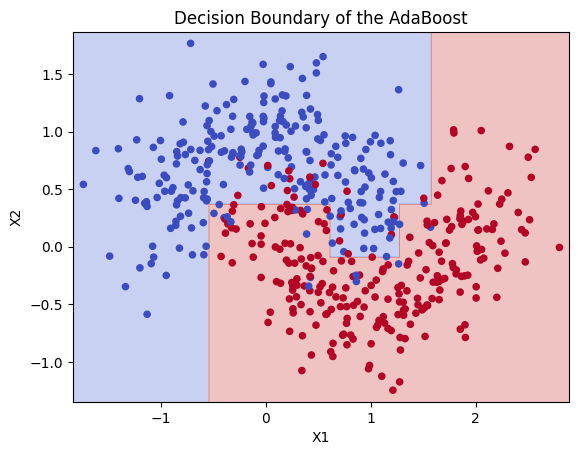

In [55]:
def plot_decision_boundaries(tree, X, y, title=""):
    # Define bounds of the plot
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    
    # Create a grid of points with a small step
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    # Use the classifier to predict the class at each grid point
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = tree.predict(grid)
    Z = Z.reshape(xx.shape)
    
    # Plot the contours
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap="coolwarm")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.show()

plot_decision_boundaries(ada_boost, X, y, title="Decision Boundary of the AdaBoost")
